<a href="https://colab.research.google.com/github/jnels13/Screening-Childrens-Writing-Level-With-NLP/blob/main/Predicting_Children's_Writing_by_Grade_Level_SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Children's Grade-Group Writing Level**

### Import Libraries

In [29]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import string
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
import six
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import gensim

import warnings
warnings.filterwarnings("ignore")
import pickle

rand_state = 16

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joenelson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# INCORPORATE THIS INTO THE MODEL (down the road):

# Predict with the testing set
topics_pred = classifier.predict(vectors_test)

# ...and measure the accuracy of the results
from sklearn.metrics import classification_report
print(classification_report(topics_test, topics_pred))

### Import Dataset

In [30]:
local_or_not = str(input("""Running on 'colab' or 'local'?"""))

Running on 'colab' or 'local'?local


In [31]:
if local_or_not == 'colab':
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0] 
    print("Confirmed that",file_name,"was uploaded.")

In [32]:
if local_or_not == 'colab':
    data = pd.read_csv(io.BytesIO(uploaded[file_name]),
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
    print("Loading remote dataset")
elif local_or_not == 'local':
    data = pd.read_csv("Data/Combined.csv",
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
    print("Loaded local dataset")
else:
    print('You need to re-start the previous cells')

Loaded local dataset


## Categorize Text Samples and Labels

In [33]:
#Number of Texts
len(data.Grade)

289

In [34]:
#Review counts per grade level
#Some texts were attributed to multiple grade levels, and thus were only assigned the lowest (for high school, it would be grade 9)

data.Grade.value_counts()

6     47
9     44
2     37
4     36
3     34
1     30
5     18
0     18
8      8
7      8
11     4
12     3
10     2
Name: Grade, dtype: int64

In [35]:
#Categorize text samples into broader grade-groups due to limited corpus size

data.loc[(data['Grade'] >= 0) & (data['Grade'] <= 2), 'Category'] = '0-2'
data.loc[(data['Grade'] >= 3) & (data['Grade'] <= 4), 'Category'] = '3-4'
data.loc[(data['Grade'] >= 5) & (data['Grade'] <= 8), 'Category'] = '5-8'
data.loc[(data['Grade'] >= 9) & (data['Grade'] <= 12), 'Category'] = '9-12'

In [36]:
#Review distribution of texts between different grade-groups
data.Category.value_counts()

0-2     85
5-8     81
3-4     70
9-12    53
Name: Category, dtype: int64

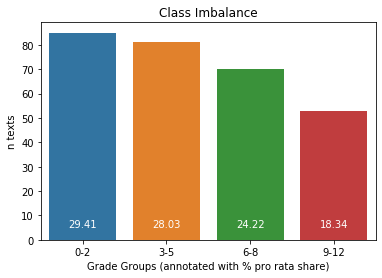

In [37]:
#Visualize potential class imbalance
imbalance=data.Category.value_counts()
sns.barplot([0,1,2,3], imbalance)
plt.xticks([0,1,2,3],['0-2', '3-5', '6-8', '9-12'])
plt.xlabel('Grade Groups (annotated with % pro rata share)')
plt.ylabel('n texts')
plt.title('Class Imbalance')
tot=len(data.Category)
for i in range(4):
    plt.annotate(round(imbalance[i]/tot*(100),2),xy=(i-.17,5), color='white')
plt.show()

In [38]:
data = data.drop(['Grade'], axis=1)

## Data Exploration & Preprocessing

In [39]:
data.Text.head()

0    How Much I Know About Space I had just gone to...
1    My Favorite Pet My cat is fluffy. His name is ...
2    Sweet Spring Spring is sweet because we can go...
3    A Happy Day One day baby Josh came home. He wa...
4    My Trip to Mexico One time I went to Mexico. I...
Name: Text, dtype: object

In [40]:
def tokenize_ (text):
    return word_tokenize(text)

In [ ]:
def apostrophes(data):
    """
    Deletes all form all forms of apostrophes
    """
    data2=data.replace('\'','')
    data3=data2.replace('``','')
    data4=data3.replace('’','')
    return(data4)

In [41]:
def stopped_ (data):
    """
    Removes stopwords and """
    stopwords_list = stopwords.words('english') #removing stopwords
    stopwords_list += list(string.punctuation)  #removing punctuation
    data2 = [w.lower() for w in data]
    return([w for w in data2 if (w not in stopwords_list)])

In [42]:
def lemma_(data):
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(w) for w in data]     
    return(data)

In [43]:
def lower(data):
    data2 = [w.lower() for w in data]
    return data2

In [44]:
data['Text_BERT'] = data.Text.apply(tokenize_).apply(lower)

In [45]:
data['Text_tokenized'] = data.Text.apply(tokenize_)

In [46]:
data['Text_lemmatized'] = data.Text_tokenized.apply(stopped_)

In [47]:
data.Text_lemmatized = data.Text_lemmatized.apply(lemma_)

In [48]:
data.head()

,Text,Category,Text_BERT,Text_tokenized,Text_lemmatized
0,How Much I Know About Space I had just gone to...,0-2,"[how, much, i, know, about, space, i, had, jus...","[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien..."
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[my, favorite, pet, my, cat, is, fluffy, ., hi...","[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor..."
2,Sweet Spring Spring is sweet because we can go...,0-2,"[sweet, spring, spring, is, sweet, because, we...","[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin..."
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[a, happy, day, one, day, baby, josh, came, ho...","[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, day, one, day, baby, josh, came, home,..."
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[my, trip, to, mexico, one, time, i, went, to,...","[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, one, time, went, mexico, blast,..."


In [49]:
type(data.Text[1])

str

#### Column "Text_lemmatized" contains the lemmatized, tokenized texts with stop-words removed and contractions expanded. 

### **Visualization of Corpus**

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 5 columns):
Text               289 non-null object
Category           289 non-null object
Text_BERT          289 non-null object
Text_tokenized     289 non-null object
Text_lemmatized    289 non-null object
dtypes: object(5)
memory usage: 11.4+ KB


In [51]:
# Create a column containing the number of words per each ORIGINAL text 
data['num_words'] = data['Text'].str.len()  

In [52]:
# Create a column containing average word length for each ORIGINAL text 
temp_token_list = list(data['Text_tokenized'])
new_token_list = []
for item in temp_token_list:
    new_token_list.append(np.average([len(w) for w in item]))
data['avg_orig_word_len'] = new_token_list

In [53]:
# Create a column containing average word length for each LEMMATIZED text 
temp_lemma_list = list(data['Text_lemmatized'])
new_lemma_list = []
for item in temp_lemma_list:
    new_lemma_list.append(np.average([len(w) for w in item]))
data['avg_lem_word_len'] = new_lemma_list

In [54]:
# Review new columns
data.head(5)

,Text,Category,Text_BERT,Text_tokenized,Text_lemmatized,num_words,avg_orig_word_len,avg_lem_word_len
0,How Much I Know About Space I had just gone to...,0-2,"[how, much, i, know, about, space, i, had, jus...","[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien...",364,3.675000,5.100000
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[my, favorite, pet, my, cat, is, fluffy, ., hi...","[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor...",209,3.037037,4.571429
2,Sweet Spring Spring is sweet because we can go...,0-2,"[sweet, spring, spring, is, sweet, because, we...","[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin...",255,3.383333,4.500000
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[a, happy, day, one, day, baby, josh, came, ho...","[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, day, one, day, baby, josh, came, home,...",130,3.121212,4.352941
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[my, trip, to, mexico, one, time, i, went, to,...","[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, one, time, went, mexico, blast,...",242,3.131148,5.037037


In [55]:
#Review descriptive statistics about the corpus before and after preprocessing
print(data.groupby('Category').describe().reset_index().sort_values('Category', ascending=True))

  Category num_words                                                                      \
               count         mean          std    min      25%     50%      75%      max   
0      0-2      85.0   406.200000   278.109982   25.0   187.00   364.0   600.00   1609.0   
1      3-4      70.0  1131.971429   570.230997  115.0   726.75  1210.0  1520.75   2725.0   
2      5-8      81.0  2784.740741  1618.645821  456.0  1852.00  2425.0  3388.00   9682.0   
3     9-12      53.0  4328.584906  2452.785265  144.0  2788.00  3568.0  5571.00  11311.0   

  avg_orig_word_len                                                                        \
              count      mean       std       min       25%       50%       75%       max   
0              85.0  3.544055  0.376101  2.857143  3.275229  3.529915  3.782609  4.625000   
1              70.0  3.632297  0.288336  2.916667  3.461047  3.639188  3.777135  4.704403   
2              81.0  3.875996  0.322997  3.301587  3.639581  3.823370  4.06

When looking at the number of words per text, they follow a relatively predicatble pattern, with the min/max, mean, and standard deviation increasing rather significantly with grade-group.  The average length of words per grade-group level does not appear to correlate nearly as much, though; average word lengths are much closer (though they do trend up with grade-group), but standard deviation and word counts do not follow the trend. The visualizations below highlight these differences:

In [ ]:
# Gather most common words across the grade-groups

concat_0_2 = []
concat_3_4 = []
concat_5_8 = []
concat_9_12 = []

for i in range(len(data)):
    if data.Category[i] == '0-2':
      concat_0_2 += data.Text_lemmatized[i]
    elif data.Category[i] == '3-4':
      concat_3_4 += data.Text_lemmatized[i]
    elif data.Category[i] == '5-8':
      concat_5_8 += data.Text_lemmatized[i]
    elif data.Category[i] == '9-12':
      concat_9_12 += data.Text_lemmatized[i]

In [ ]:
group_0_2_freqdist = FreqDist(concat_0_2)
group_3_4_freqdist = FreqDist(concat_3_4)
group_5_8_freqdist = FreqDist(concat_5_8)
group_9_12_freqdist = FreqDist(concat_9_12)

In [ ]:
#Visualize Frequency Distribution of 10 most common
n=10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
sns.barplot([x[0] for x in group_0_2_freqdist.most_common(n)], [x[1] for x in group_0_2_freqdist.most_common(n)], ax=ax1)
sns.barplot([x[0] for x in group_3_4_freqdist.most_common(n)], [x[1] for x in group_3_4_freqdist.most_common(n)], ax=ax2)
sns.barplot([x[0] for x in group_5_8_freqdist.most_common(n)], [x[1] for x in group_5_8_freqdist.most_common(n)], ax=ax3)
sns.barplot([x[0] for x in group_9_12_freqdist.most_common(n)],[x[1] for x in group_9_12_freqdist.most_common(n)],ax=ax4)
#Subplot titles
ax1.title.set_text('K-2nd')
ax2.title.set_text('3rd-4th')
ax3.title.set_text('5th-8th')
ax4.title.set_text('9th-12th')

# ax1.set_xlabel('Preprocessed Texts', size='large')

fig.suptitle('10 Most Common Words Per Grade Group', size='x-large')
plt.show()

The foregoing is the result of an iterative process; is is NOT the original "top 10 words."  Words that appeared across the top 10 in at least three different grade-groups were added to the stop-word list and removed.  

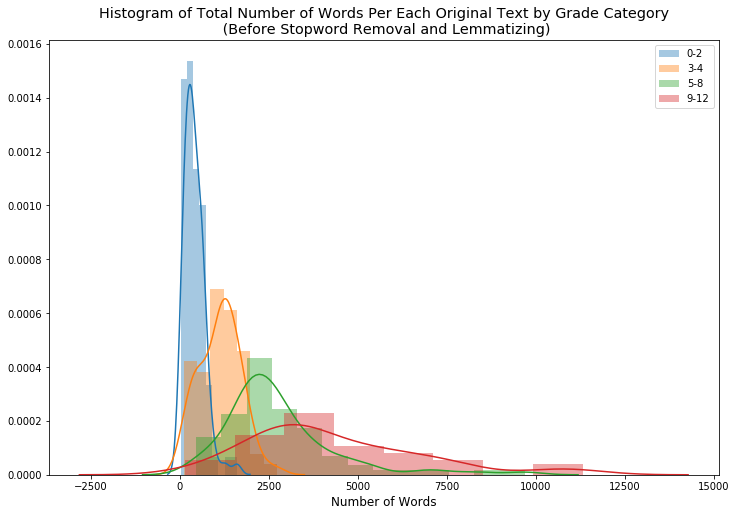

In [56]:
#Distribution of Number of Words per Text by Grade-Group Level
plt.figure(figsize=(12,8))
plt.title('Histogram of Total Number of Words Per Each Original Text by Grade Category\n (Before Stopword Removal and Lemmatizing)', size='x-large')
for name, group in data.groupby('Category'):
    sns.distplot(group['num_words'], label=name)
plt.legend()
plt.xlabel('Number of Words', size='large')
plt.show()

The text lengths for K-2 grade are much shorter than the higher grades. Lengths of middle and high school texts are much more comparable.

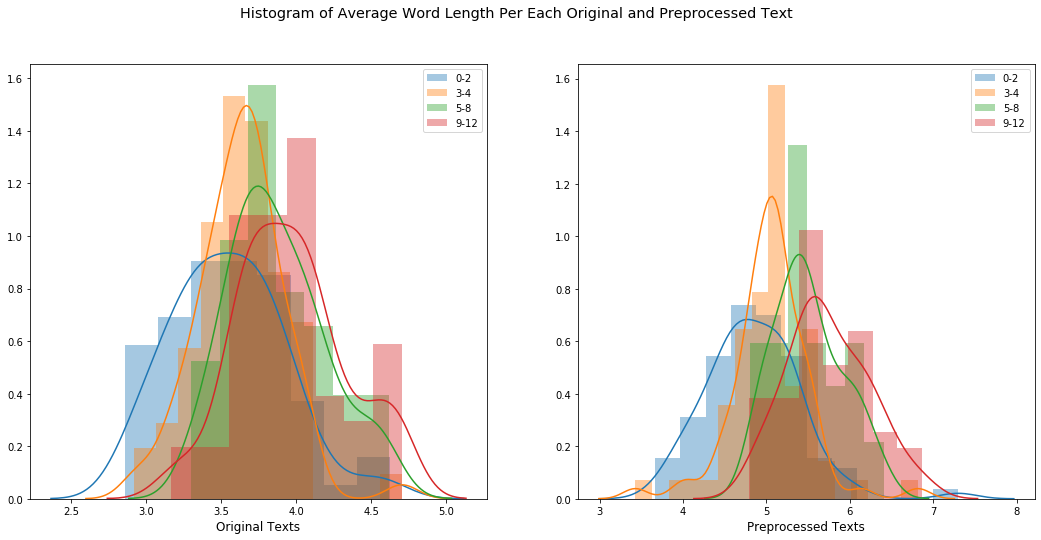

In [57]:
#Visualize distribution of word lengths between original and preprocessed texts


fig, ax = plt.subplots(1,2, figsize=(18, 8))
ax0 = ax[0]
ax1 = ax[1]
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_orig_word_len'], label=name, ax=ax0)
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_lem_word_len'], label=name, ax=ax1)
ax0.set_xlabel('Original Texts', size='large')
ax0.legend()
ax1.set_xlabel('Preprocessed Texts', size='large')
ax1.legend()
fig.suptitle('Histogram of Average Word Length Per Each Original and Preprocessed Text', size='x-large')
plt.show()

    

Overall, there is a LOT of overlap in the distributions between all of the grade-groups, with the most striking being between the upper two.  The distributions of word lengths are much higher in the stopped/lemmatized group (peaking between 4-5 for stopped/lemmatized texts, compared to about 3.5 for the original texts.  The distributions of the original texts are also much closer together, likely due to the inclusion of the stop words. 

## Visualize the Text Itself: Wordclouds by Grade-Group

In [1]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
def printmd(string):
    display(Markdown(string))

# Generate word cloud
def make_wordcloud(category_):
  wordcloud = WordCloud(width = 800, height = 600, 
                        random_state=rand_state, 
                        background_color='white', 
                        colormap='Dark2', 
                        collocations=False, 
                        stopwords = STOPWORDS).generate(' '.join(data['Text'].loc[data['Category']== category_]))
  # plot_cloud(wordcloud)
  # plt.title(category_)
  plt.figure( figsize=(8,6), facecolor='w')
  plt.imshow(wordcloud)
  plt.axis("off")
  x = '## **Grade-Group ' + category_ + '**'
  printmd(x)
  plt.tight_layout(pad=0)
  plt.show()

In [ ]:
make_wordcloud('0-2'), make_wordcloud('3-4')
make_wordcloud('5-8'), make_wordcloud('9-12')

Dogs and cats are important in younger grade levels, but drop off as age increases. "Mom" is always prominent, but becomes "mother" in high school (and "coffee" appears). "People" grows in frequency in middle and high school. "Time" appears to grow in frequency as grade levels increase.  

# **Weight and Vectorize the Texts**

#### Text Features
Text ==> STRING of cased text with stopwords and punctuation<br>
Text_tokenized ==> LIST of cased with stopwords and punctuation<br>
Text_BERT ==> LIST of tokenized and lower cased<br>
Text_lemmatized ==> LIST of tokenized, lower-case with stopwords and punctuation removed

### Different Train-test Splits for Different Experiments

In [62]:
# Fully preprocessed texts -- plain
X_train, X_test, y_train, y_test = train_test_split(
    data['Text_lemmatized'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [63]:
# Tokenized and lower-cased texts "bert"
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    data['Text_BERT'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [64]:
# Untouched (only tokenized) - "cased_tok"
X_train_cased_tok, X_test_cased_tok, y_train_cased_tok, y_test_cased_tok = train_test_split(
    data['Text_tokenized'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [65]:
# Untouched - "cased"
X_train_cased, X_test_cased, y_train_cased, y_test_cased = train_test_split(
    data['Text'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [66]:
# Y labels to use with all models
# UDPATE THE END OF LINES 3-5 WITH TEH SUFFIXES FROM ABOVE
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train_cased)
y_test = Encoder.fit_transform(y_test_cased)

pickle_out = open("Encoder.pkl", "wb") 
pickle.dump(Encoder, pickle_out) 
pickle_out.close()

### **TD-IDF Weighting**

In [68]:
# Unigrams on Lemmatized Text
# lemmas = data['Text_lemmatized'].apply(lambda x: ' '.join(x))

# UPDATE X_train AND _test WITH RELEVANT SPLIT FROM ABOVE
# Train_X = X_train_cased.apply(lambda x: ' '.join(x))
# Test_X  = X_test_cased.apply(lambda x: ' '.join(x))

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X_train_cased)

# # Pickle Tfidf_vect 
# pickle_out = open("Tfidf_vect.pkl", "wb") 
# pickle.dump(Tfidf_vect, pickle_out) 
# pickle_out.close()

X_train_tfidf = Tfidf_vect.transform(X_train_cased)
X_test_tfidf = Tfidf_vect.transform(X_test_cased)

In [228]:
#Use SMOTE to account for class imbalances

# sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=rand_state)
# X_train_tfidf,y_train_tfidf = sm.fit_resample(X_train_tfidf, y_train) 

In [69]:
pd.DataFrame(X_train_tfidf).shape

(202, 1)

### **Word2vec Vectorization**

In [170]:
num_features=300
model = gensim.models.Word2Vec(data.Text_lemmatized, 
                               size=num_features, 
                               min_count=2, 
                               workers=4, 
                               seed=1, 
                               iter=50, window=5)

In [171]:
model.wv.syn0.shape

(4721, 300)

In [172]:
# Pickle model 
pickle_out = open("w2v_model.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [173]:
#Just for fun, to see if it's working
model.wv.doesnt_match("red green bus".split())

'bus'

In [174]:
# Function to average all word vectors in a paragraph (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [175]:
# Function for calculating the average feature vector (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [176]:
trainDataVecs = getAvgFeatureVecs(X_train, model, num_features)
testDataVecs =  getAvgFeatureVecs(X_test, model, num_features)

Review 0 of 202
Review 0 of 87


In [177]:
trainDataVecs.shape, testDataVecs.shape

((202, 300), (87, 300))

In [178]:
X_train_w2v,y_train_w2v = sm.fit_sample(trainDataVecs, y_train)  #WHAT IF I DON'T USE THE IMBALANCE CORRECTION???????????????????

# **BERT** 
Using BERT as a Service 

In [70]:
# %tensorflow_version 1.x
!pip install bert-serving-client
!pip install -U bert-serving-server[http]

Requirement already up-to-date: bert-serving-server[http] in /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages (1.10.0)


**RUN THE FOLLOWING:** 
<br>**uncased:** bert-serving-start -model_dir /Users/joenelson/uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 50 
<br>**cased:** bert-serving-start -model_dir /Users/joenelson/cased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 50 
<br>(to start the server)

In [71]:
# Open a connecton to the server
from bert_serving.client import BertClient
bc = BertClient()

In [181]:
# list_text = ['you need to use tensorflow 1', 'tf2 does not work']
# embedded_text = bc.encode(list_text)
# print(embedded_text, '\n',embedded_text.shape)

In [74]:
#Convert to strings for BERT
X_train_prebert = [str(i) for i in X_train_cased]
X_test_prebert = [str(i) for i in X_test_cased]

In [75]:
# get the embedding for train and val sets
X_train = bc.encode(X_train_prebert)
X_test = bc.encode(X_test_prebert)

In [83]:
X_train.shape

(202, 768)

# **Models**

In [77]:
def dummy_classifier(X_train, X_test, y_train, y_test):
  dummy_clf = DummyClassifier(strategy="stratified", random_state=rand_state)
  dummy_clf.fit(X_train, y_train)
  dummy_accuracy = (round(dummy_clf.score(X_test, y_test)*100,3))
  return(dummy_accuracy)

In [78]:
def svm_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs GridSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_svm = svm.SVC(random_state=rand_state)
  param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                'degree': [1,2,3,4]} 
  gs_svm = GridSearchCV(SVC(), param_grid, cv=5)
  gs_svm.fit(X_train,y_train)
  best = gs_svm.best_params_
  SVM = svm.SVC(C=best['C'], kernel=best['kernel'], degree=best['degree'], gamma=best['gamma'], random_state=rand_state)
  SVM.fit(X_train,y_train)
  y_hat = SVM.predict(X_test)
  print('SVM best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [79]:
def rf_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs a random forest and returns an 
  Accuracy Score and F1 Score.
  This model was manually tuned using the
  n_estimators parameter during the model
  creation process.
  """
  forest = RandomForestClassifier(n_estimators = 110, random_state=rand_state)
  forest_tf = forest.fit(X_train,y_train)
  y_hat = forest.predict(X_test)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [80]:
def xgb_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs GridSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_xgb = xgb.XGBClassifier(random_state=rand_state)
  param_grid = {'learning_rate': [0.3],  
                'n_estimators': [100,150], 
                'max_depth': [3,6,8],
                'gamma': [0.1,0.4]} 
  gs_xgb = GridSearchCV(clf_xgb, param_grid, cv=5)
  gs_xgb.fit(X_train, y_train)
  best = gs_xgb.best_params_
  XGB = xgb.XGBClassifier(learning_rate=best['learning_rate'], 
                          n_estimators=best['n_estimators'], 
                          max_depth=best['max_depth'],
                          gamma=best['gamma'],
                          random_state=rand_state)
  XGB.fit(X_train, y_train)
  y_hat = XGB.predict(X_test)
  print('XGB best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [81]:
def lr_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y; runs vanilla logistic regression,
  returns an Accuracy Score and F1 Score.
  """
  clf_lr = LogisticRegression(random_state=rand_state)
#   param_grid = {'learning_rate': [0.3],  
#                 'n_estimators': [100,150], 
#                 'max_depth': [3,6,8],
#                 'gamma': [0.1,0.4]} 
#   gs_xgb = GridSearchCV(clf_xgb, param_grid, cv=5)
#   gs_xgb.fit(X_train, y_train)
#   best = gs_xgb.best_params_
#   XGB = xgb.XGBClassifier(learning_rate=best['learning_rate'], 
#                           n_estimators=best['n_estimators'], 
#                           max_depth=best['max_depth'],
#                           gamma=best['gamma'],
#                           random_state=rand_state)
  clf_lr.fit(X_train, y_train)
  y_hat = clf_lr.predict(X_test)
#   print('XGB best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [82]:
def mnb(X_train, X_test, y_train, y_test):
    clf_nb = MultinomialNB()
    clf_nb.fit(X_train, y_train)
    y_hat = clf_nb.predict(X_test)
    return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [28]:
# try_ = xgb.XGBClassifier(random_state=rand_state)
# try_.get_params().keys()

In [192]:
def combined_models(X_train, X_test, y_train, y_test):
  """
  Runs all four models used in this notebook, including the 
  dummy classifier, SVM, Random Forest, and XGBoos models.
  Takes full train-test-split for X,y.
  """
  dum = dummy_classifier(X_train, X_test, y_train, y_test)
  svm = svm_classifier(X_train, X_test, y_train, y_test)
  rfc = rf_classifier(X_train, X_test, y_train, y_test)
  xgb = xgb_classifier(X_train, X_test, y_train, y_test)
  print('Dummy Classifier Accuracy:', dum)
  print('SVM Classifier Accuracy, F1 Score (macro):', svm)
  print('Random Forest Accuracy, F1 Score (macro):', rfc)
  print('XG Boost Accuracy, F1 Score (macro):', xgb)
  return()


## **Application of Models to Datasets**

### Iteration 1: Initial, Multi-Source Dataset <br>(don't run these cells after initial dataset is loaded)

In [193]:
# #Test the TF-IDF weighted texts
# combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

In [194]:
# #Test the Word2vec vectorized texts
# combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

### Iteration 2: Single-Source, Common-Core Dataset

In [195]:
# #Test the TF-IDF weighted texts
# combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

In [196]:
# #Test the Word2vec vectorized texts
# combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

### Iteration 3: Combined Dataset

bert_splits = X_train_bert, X_test_bert, y_train_bert, y_test_bert
tfidf_splits = X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test
w2v_splits = X_train_w2v, testDataVecs, y_train_w2v, y_test

#### BERT Classifiers
X_train_bert, X_test_bert, y_train_bert, y_test_bert

In [84]:
#DUMMY
dummy_classifier(X_train, X_test, y_train, y_test)

25.287

In [85]:
#LOGISTIC REGRESSION
lr_classifier(X_train, X_test, y_train, y_test)

(55.172, 54.677)

In [86]:
#SVM CLASSIFIER
svm_classifier(X_train, X_test, y_train, y_test)

SVM best params: {'C': 100, 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


(62.069, 58.604)

In [87]:
#XG_BOOST CLASSIFIER
xgb_classifier(X_train, X_test, y_train, y_test)

XGB best params: {'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100}


(41.379, 38.804)

In [89]:
#RANDOM FOREST -- unresolveable ValueError
# rf_classifier(X_train, X_test, y_train, y_test)

In [132]:
#MULTINOMIAL NAIVE BAYES -- Won't work with negative values
# mnb(X_train_bert, X_test_bert, y_train_bert, y_test_bert)

#### **TFIDF Classifiers**
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test

In [236]:
#DUMMY
dummy_classifier(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

16.092

In [237]:
#LOGISTIC REGRESSION
lr_classifier(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

(51.724, 49.305)

In [238]:
#SVM CLASSIFIER
svm_classifier(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}


(44.828, 30.231)

In [239]:
#XG_BOOST CLASSIFIER
xgb_classifier(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

XGB best params: {'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100}


(54.023, 48.617)

In [240]:
#RANDOM FOREST 
rf_classifier(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

(55.172, 48.008)

In [241]:
#MULTINOMIAL NAIVE BAYES 
mnb(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

(41.379, 41.207)

#### **TFIDF/Bigram Classifiers**
X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test

In [235]:
#DUMMY
dummy_classifier(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [202, 236]

In [203]:
#LOGISTIC REGRESSION
lr_classifier(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

(49.425, 45.121)

In [204]:
#SVM CLASSIFIER
svm_classifier(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

SVM best params: {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}


(44.828, 28.303)

In [205]:
#XG_BOOST CLASSIFIER
xgb_classifier(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

XGB best params: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


(54.023, 50.732)

In [206]:
#RANDOM FOREST 
rf_classifier(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

(52.874, 46.975)

In [207]:
#MULTINOMIAL NAIVE BAYES 
mnb(X_train_tfidf_bg, X_test_tfidf_bg, y_train_tfidf, y_test)

(41.379, 41.11)

#### WORD2VEC Classifiers
X_train_w2v, testDataVecs, y_train_w2v, y_test

In [208]:
#DUMMY
dummy_classifier(X_train_w2v, testDataVecs, y_train_w2v, y_test)

16.092

In [209]:
#LOGISTIC REGRESSION
lr_classifier(X_train_w2v, testDataVecs, y_train_w2v, y_test)

(39.08, 39.018)

In [210]:
#SVM CLASSIFIER
svm_classifier(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}


(48.276, 45.334)

In [211]:
#XG_BOOST CLASSIFIER
xgb_classifier(X_train_w2v, testDataVecs, y_train_w2v, y_test)

XGB best params: {'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


(40.23, 39.763)

In [212]:
#RANDOM FOREST 
rf_classifier(X_train_w2v, testDataVecs, y_train_w2v, y_test)

(43.678, 42.757)

In [214]:
#MULTINOMIAL NAIVE BAYES -- Won't work with negative values
# mnb(X_train_w2v, testDataVecs, y_train_w2v, y_test)

# **Final Model** 

### Set up best-functioning models for TF-IDF and Word2vec
<br> (Initial use of TFIDF alone oversimplified)

In [ ]:
clf_xgb_tfidf = xgb.XGBClassifier(gamma=0.1, learning_rate=0.3, max_depth=8, n_estimators=100, random_state=rand_state)
clf_xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)

pickle_out = open("clf_xgb_tfidf.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

#Test to ensure same performance
y_hat = clf_xgb_tfidf.predict(X_test_tfidf)
print(round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

52.874 50.612


In [ ]:
clf_rf_w2v = RandomForestClassifier(n_estimators = 110, random_state=rand_state)
clf_rf_w2v.fit(X_train_w2v, y_train_w2v)

pickle_out = open("clf_rf_w2v.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

#Test to ensure same performance
y_hat2 = clf_rf_w2v.predict(testDataVecs)
print(round(accuracy_score(y_test, y_hat2)*100,3), round(f1_score(y_test, y_hat2, average='macro')*100,3))

50.575 49.355


# PICKLE OUT THE ABOVE TWO MODELS 1ST TWO LINES ONLY

In [ ]:
def preprocess_tfidf(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = Tfidf_vect.transform(text4)
  return(text5)

In [ ]:
def preprocess_w2v(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = getAvgFeatureVecs(text4, model, num_features)
  return(text5)

### **Input text sample to be predicted:**

In [ ]:
text_sample = (input("Paste the text of the student's work here:"))

Paste the text of the student's work here:


In [ ]:
predict_me_tfidf = preprocess_tfidf(text_sample)
predict_me_w2v = preprocess_w2v(text_sample)

NameError: name 'tokenize_' is not defined

In [ ]:
print('Predicted writing level using TF-IDF weights:',Encoder.inverse_transform(clf_xgb_tfidf.predict(predict_me_tfidf)))
print('Predicted writing level using Word2vec Vectors:',Encoder.inverse_transform(clf_rf_w2v.predict(predict_me_w2v)))

NameError: name 'Encoder' is not defined